<a href="https://colab.research.google.com/github/cool60334/111-TibaMe-AI-03-Deep-Learning/blob/main/DL_Transfer_Learning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 取得檔案

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 解壓縮

import zipfile
path = "/content/drive/MyDrive/Colab Notebooks/DL/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

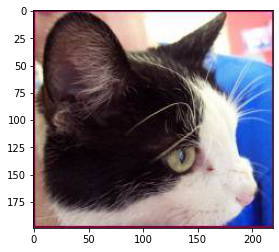

In [3]:
# 取得檔案路徑

import glob
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[2000]))

# 建立訓練測試資料

In [4]:
import random
import pandas as pd

# 將順序打亂

dogs = glob.glob("train/dog.*")
random.shuffle(dogs)
cats = glob.glob("train/cat.*")
random.shuffle(cats)

# 先不讀取圖片，建立表格存放檔案路徑

# 取900張狗和貓做訓練資料

train = pd.DataFrame({
    "path":dogs[:900] + cats[:900],
    "target":[0] * 900 + [1] * 900
})

# 取50張狗和貓做驗證資料

validate = pd.DataFrame({
    "path":dogs[900:950] + cats[900:950],
    "target":[0] * 50 + [1] * 50
})

# 取50張狗和貓做測試資料

test = pd.DataFrame({
    "path":dogs[950:1000] + cats[950:1000],
    "target":[0] * 50 + [1] * 50
})

# 查看VGG16 summary

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

# include_top=False -> 不用VGG16原本的MLP

vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# 建立模型

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization


# CNN(眼睛)
# vgg.layers是一個CNN layers list
# 不再重新訓練眼睛

for l in vgg.layers:
    l.trainable = False

# MLP(腦袋)

layers = [
    BatchNormalization(),  # 共2048個參數，其中512個平均和512個標準差不用訓練(原本的平均和標準差)，另外的512個平均和512個標準差要隨機梯度下降找最好的
    GlobalAveragePooling2D(),  # GAP 把7*7的圖的所有分數做平均，將位置資訊撇除，最後剩下1*512層共512個值
    Dense(2, activation="softmax")
]

layers = vgg.layers + layers
model = Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

# 確定模型訓練方式

In [7]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),  # Sparse表示保留非0位置
       optimizer="adam",
       metrics=["accuracy"])

In [8]:
# 將所有資料都轉成np.array

import numpy as np
x_train = np.array(train["path"])
y_train = np.array(train["target"])
x_validate = np.array(validate["path"])
y_validate = np.array(validate["target"])
x_test = np.array(test["path"])
y_test = np.array(test["target"])

# 資料預處理函式

In [9]:
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input


def get_data(x, y, batch=None):  # batch表示一次要讀幾張圖，batch=None -> 讀取全部的圖
    
    if batch is not None:

        # 隨機取batch個位置(idx)

        idx = np.random.randint(0, len(x), size=batch)
        x, y = x[idx], y[idx]


    # img_pre: preprocess過後的圖片
    # img_ori: 沒有preprocess的圖片

    img_pre, img_ori = [], []


    # 走過剛剛隨機取出的訓練資料x

    for p in x:

        # 讀取圖片並且預處理
        img = Image.open(p).convert("RGB").resize((224, 224))
        img = np.array(img)
        img_pre.append(preprocess_input(img))  # 用VGG16原本的預處理方式處理圖片
        img_ori.append(img)

    
    # 回傳(預處理過後圖片, 沒處理圖片, 答案)
    return (np.array(img_pre), np.array(img_ori), y)

# 使用範例
# x, x_ori, y = get_data(x_train, y_train, 10)
# print(x.shape)
# print(x_ori.shape)
# print(y.shape)
# print(x)

In [10]:
# validate和test全部讀出來
xv, xv_ori, yv = get_data(x_validate, y_validate)
xt, xt_ori, yt = get_data(x_test, y_test)
print(xv.shape)
print(xt.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)


# 訓練模型

In [ ]:
# train_on_batch

for i in range(150):
    x, _, y = get_data(x_train, y_train, batch=20)  # 下底線 -> 表示目前不需要用到原圖(img_ori)，不用為變數命名
    result = model.train_on_batch(x, y)
    print("train:", result)
    result = model.test_on_batch(xv, yv)
    print("validate:", result)
    print("-" * 15, i, "end", "-" * 15)

# 進行預測

In [12]:
model.predict(x)

1/1 [==============================] - 5s 5s/step


array([[9.8481166e-01, 1.5188299e-02],
       [2.7236134e-01, 7.2763866e-01],
       [9.0579420e-01, 9.4205789e-02],
       [6.2867880e-02, 9.3713212e-01],
       [9.9965811e-01, 3.4183948e-04],
       [9.9702126e-01, 2.9786723e-03],
       [9.9902177e-01, 9.7822701e-04],
       [2.9223200e-02, 9.7077686e-01],
       [8.3504859e-03, 9.9164951e-01],
       [1.5672952e-01, 8.4327042e-01],
       [5.9638020e-02, 9.4036198e-01],
       [5.0223872e-02, 9.4977611e-01],
       [9.5919663e-01, 4.0803358e-02],
       [9.9066240e-01, 9.3376245e-03],
       [1.1024058e-02, 9.8897600e-01],
       [3.0067548e-01, 6.9932449e-01],
       [9.9497080e-01, 5.0291368e-03],
       [3.6563281e-02, 9.6343672e-01],
       [9.7881520e-01, 2.1184772e-02],
       [4.4830623e-01, 5.5169380e-01]], dtype=float32)

In [13]:
pre = model.predict(xt).argmax(axis=1)
model.evaluate(xt, yt)

4/4 [==============================] - 1s 101ms/step - loss: 0.1071 - accuracy: 0.9700


[0.10714074224233627, 0.9700000286102295]

# 找出預測錯誤的圖

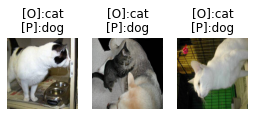

In [14]:
import numpy as np
# 找出True(預測錯誤)的位置
idx = np.nonzero(pre != yt)[0]
idx = idx[:200]
pre_false_label = yt[idx]
pre_false_pre = pre[idx]
pre_false_img = xt_ori[idx]
# !
trans = ["dog", "cat"]
plt.figure(figsize=(15, 5))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_label[i]], trans[pre_false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

# 抓網路上的圖測試模型

url:https://cdn2.ettoday.net/images/2253/2253152.jpg
1/1 [==============================] - 0s 18ms/step
dog 的機率: 0.857
cat 的機率: 0.143


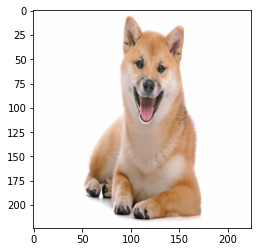

In [25]:
import requests
# pillow
from PIL import Image
url = input("url:")
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB").resize((224, 224))
img_np = np.array(img).reshape(1, 224, 224, 3)
# (32, 32, 3) -> (1, 32, 32, 3)
img_np_pre = preprocess_input(img_np)
proba = model.predict(img_np_pre)[0]
for p, n in zip(proba, trans):
    print(n, "的機率:", round(p, 3))
plt.imshow(img)